In [1]:
library(anndata)
library(Signac)
library(Seurat)
library(anndata)

Attaching SeuratObject

Attaching sp



In [12]:
library(Signac)
library(Seurat)
#library(EnsDb.Mmusculus.v102)
library(BSgenome.Mmusculus.UCSC.mm10)
#library(pastecs)
library(stringr)

In [63]:
seurat <- readRDS("/Users/dominik.klein/data/E14-E15_adata_filtered_seurat_merged_peaks.rds")

In [64]:
adata <- read_h5ad("/Users/dominik.klein/data/endocrine_refinement.h5ad")

In [65]:
adata

AnnData object with n_obs × n_vars = 16918 × 14663
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets',

In [66]:
adata$obs$index_name <- rownames(adata$obs)

In [67]:
adapt_obs_names <- function(x){
    tmp <- str_split(x, "-")[[1]]
    if(tmp[3] == "0"){
        prefix <- "E14-5"
        }
    else{
        prefix <- "E15-5"
        }
    return(paste(prefix, "_", tmp[1], "-", tmp[2], sep = ""))
    }

In [68]:
adata$obs$obs_name_adapted <- sapply(adata$obs$index_name, adapt_obs_names)

In [69]:
seurat <- seurat[,adata$obs$obs_name_adapted]

In [70]:
seurat

An object of class Seurat 
475329 features across 16918 samples within 3 assays 
Active assay: ATAC_merged (228259 features, 228259 variable features)
 2 other assays present: RNA, ATAC
 1 dimensional reduction calculated: lsi

In [72]:
seurat@meta.data$rowname <- rownames(seurat@meta.data)

In [73]:
merged_obs <- merge(seurat@meta.data, adata$obs, by.x="rowname", by.y="obs_name_adapted")

In [75]:
seurat@meta.data <- merged_obs

In [76]:
seurat

An object of class Seurat 
475329 features across 16918 samples within 3 assays 
Active assay: ATAC_merged (228259 features, 228259 variable features)
 2 other assays present: RNA, ATAC
 1 dimensional reduction calculated: lsi

In [13]:
# extract gene annotations from EnsDb
#annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v102)

# rename chromosome names to match cellranger output
BSgenome.Mmusculus.UCSC.mm10.renamed <- renameSeqlevels(BSgenome.Mmusculus.UCSC.mm10, value = str_replace(str_replace(seqnames(BSgenome.Mmusculus.UCSC.mm10), pattern = "chr", replacement = ""), pattern = "M", replacement = "MT"))

In [57]:
seurat

An object of class Seurat 
475329 features across 16918 samples within 3 assays 
Active assay: ATAC_merged (228259 features, 228259 variable features)
 2 other assays present: RNA, ATAC
 1 dimensional reduction calculated: lsi

In [78]:
seurat <- RegionStats(seurat, genome = BSgenome.Mmusculus.UCSC.mm10.renamed)

In [126]:
# general endocrine (progenitor) markers
c1 <- c("Fev", "Gcg", "Ghrl", "Ins2", "Pyy")
# delta markers
c2 <- c("Hhex", "Sst", "Cd24a", "Rbp4") 
# Cellrank delta markers
c3 <- c("Hadh", "Isl1", "Pkhd1", "Map2k4", "Msi1", "Nefl")

c <- c(c1, c2, c3)

In [128]:
seurat <- LinkPeaks(
  object = seurat,
  peak.assay = "ATAC_merged",
  expression.assay = "RNA",
  genes.use = c
)

Testing 15 genes and 228257 peaks



In [167]:
seurat[["ATAC_merged"]]@links[seurat[["ATAC_merged"]]@links$gene=="Sst"]

GRanges object with 1 range and 5 metadata columns:
      seqnames            ranges strand |     score        gene
         <Rle>         <IRanges>  <Rle> | <numeric> <character>
  [1]       16 23842875-23890958      * | 0.0510728         Sst
                      peak    zscore      pvalue
               <character> <numeric>   <numeric>
  [1] 16-23842405-23843344   7.47733 3.79231e-14
  -------
  seqinfo: 9 sequences from an unspecified genome; no seqlengths

## General endocrine markers

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message:
"Removed 13 rows containing missing values (geom_segment)."


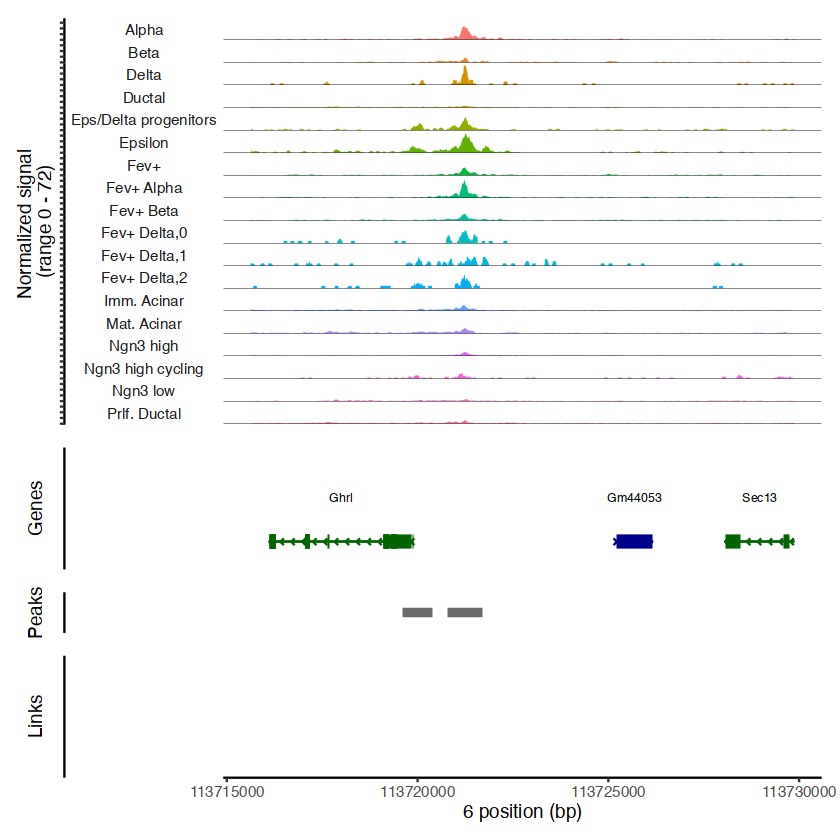

In [168]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Ghrl",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Fev+ Delta,2 maybe Eps progenitors? 

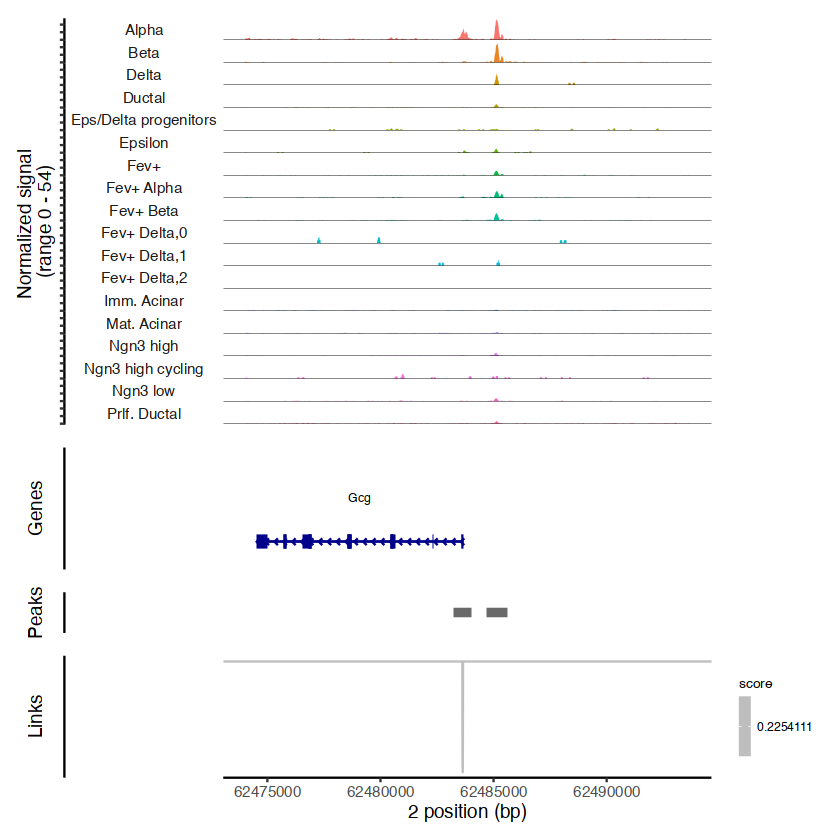

In [131]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Gcg",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

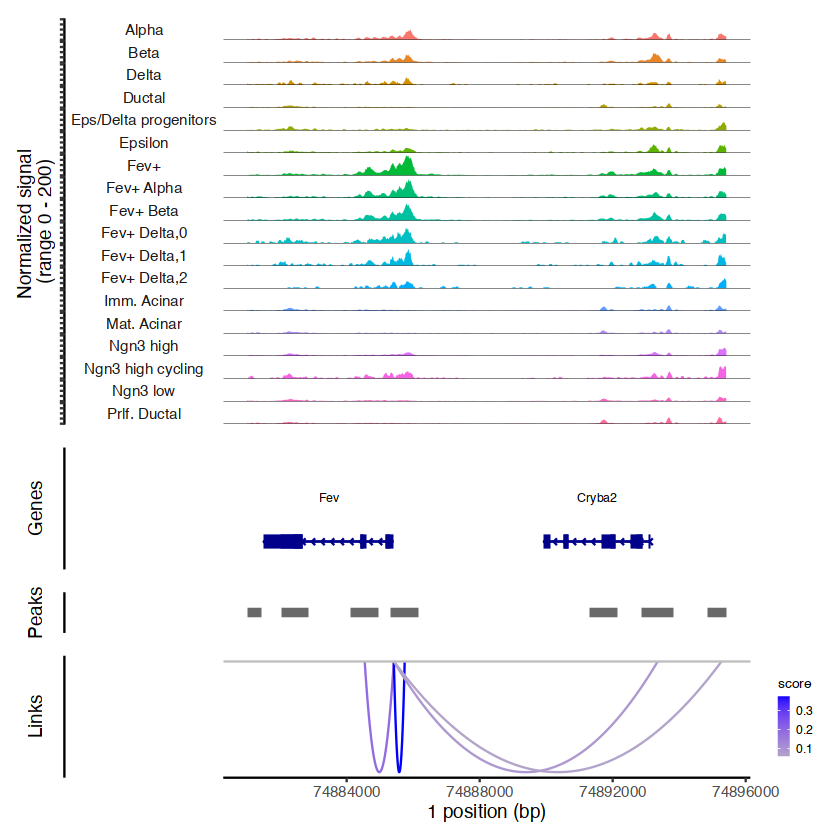

In [132]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Fev",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

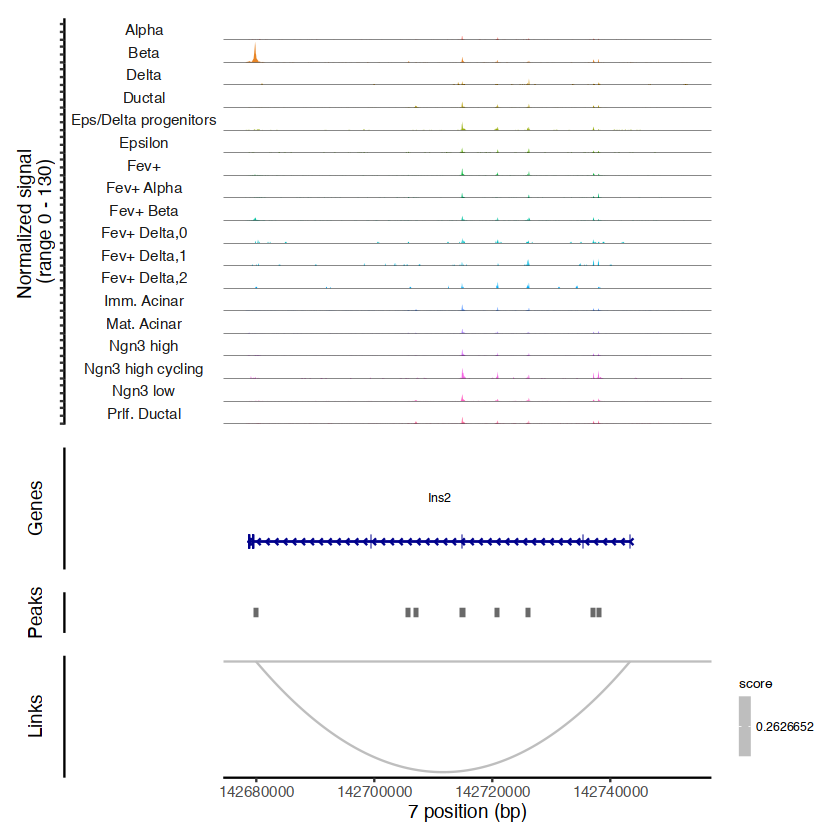

In [133]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Ins2",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

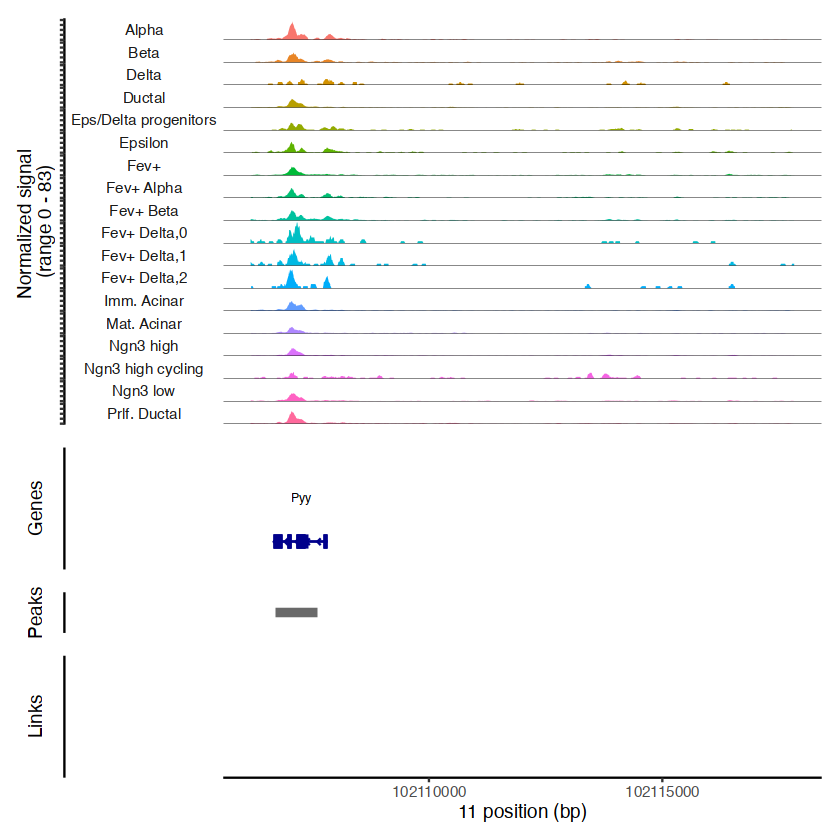

In [134]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Pyy",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

## Delta markers

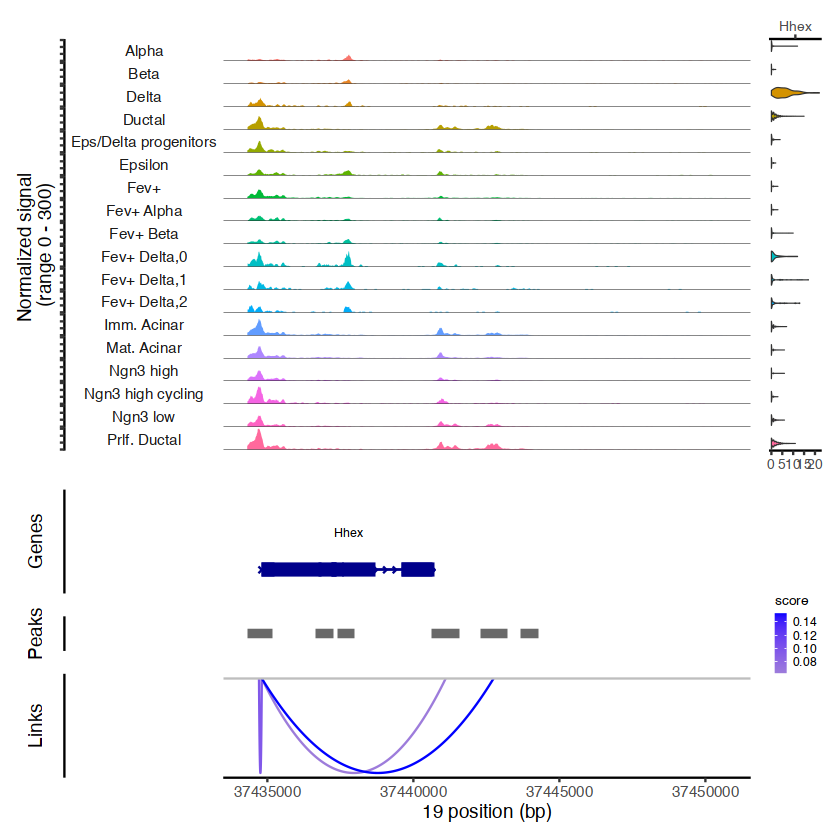

In [161]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Hhex",
    features = "Hhex",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

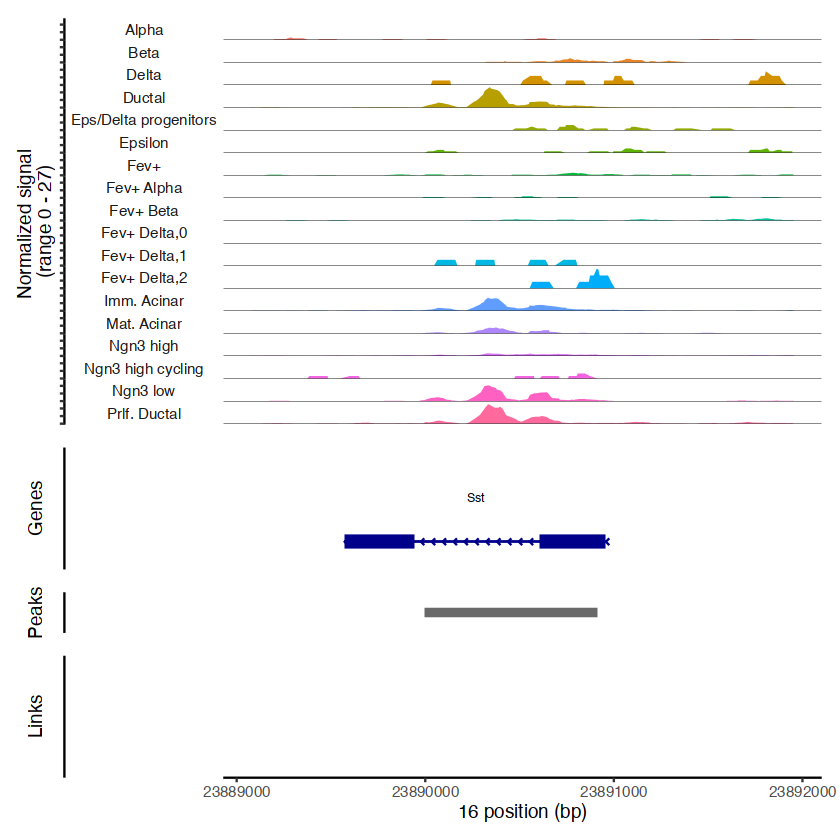

In [170]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Sst",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 1000,
)
p1

Warning message:
"Removed 41 rows containing missing values (geom_segment)."


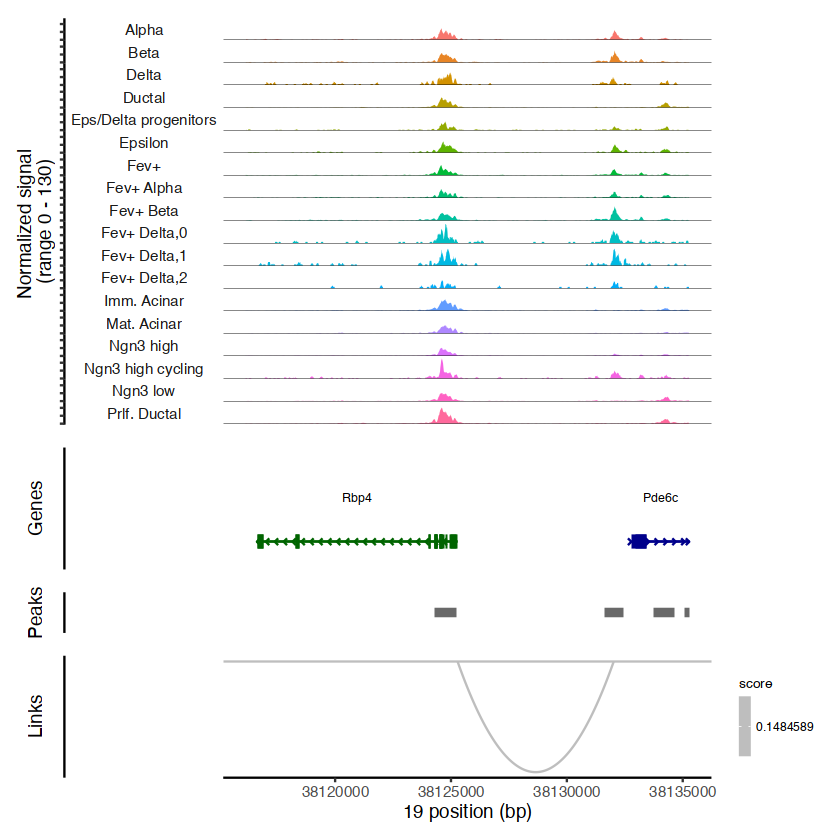

In [137]:
Idents(seurat) <- "split_fev_delta"f

p1 <- CoveragePlot(
  object = seurat,
  region = "Rbp4",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message:
"Removed 15 rows containing missing values (geom_segment)."


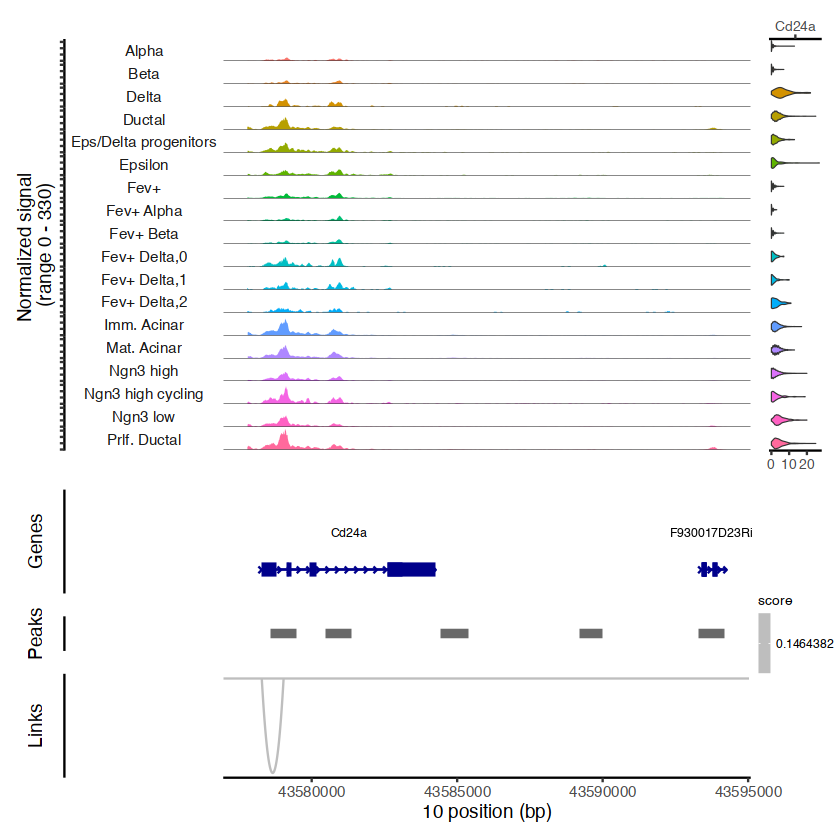

In [169]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Cd24a",
    features = "Cd24a",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)

p1

## CellRank delta markers

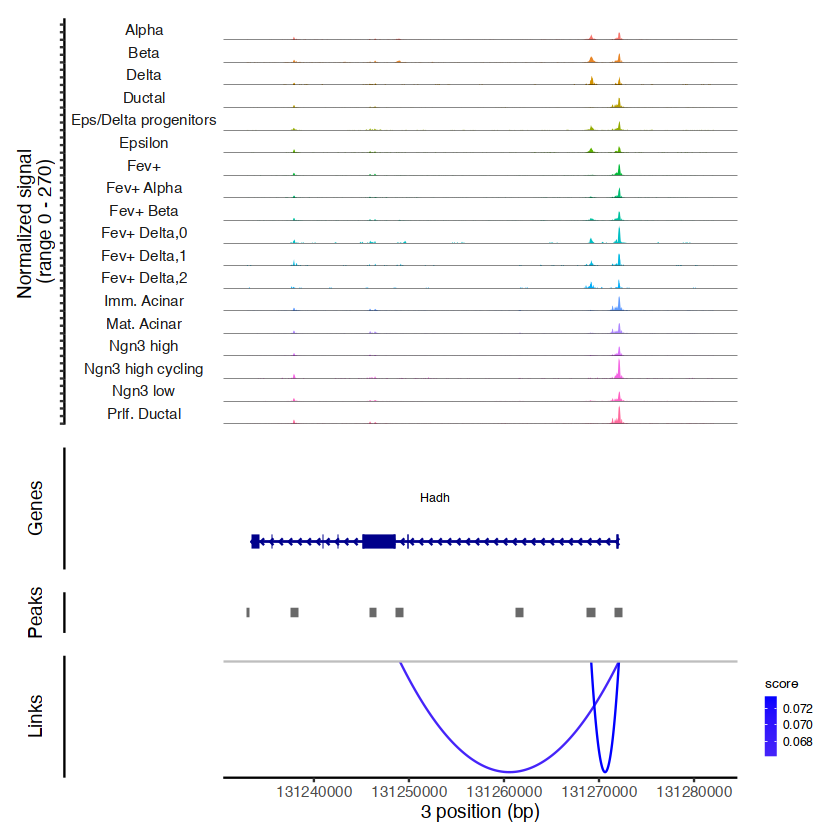

In [139]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Hadh",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

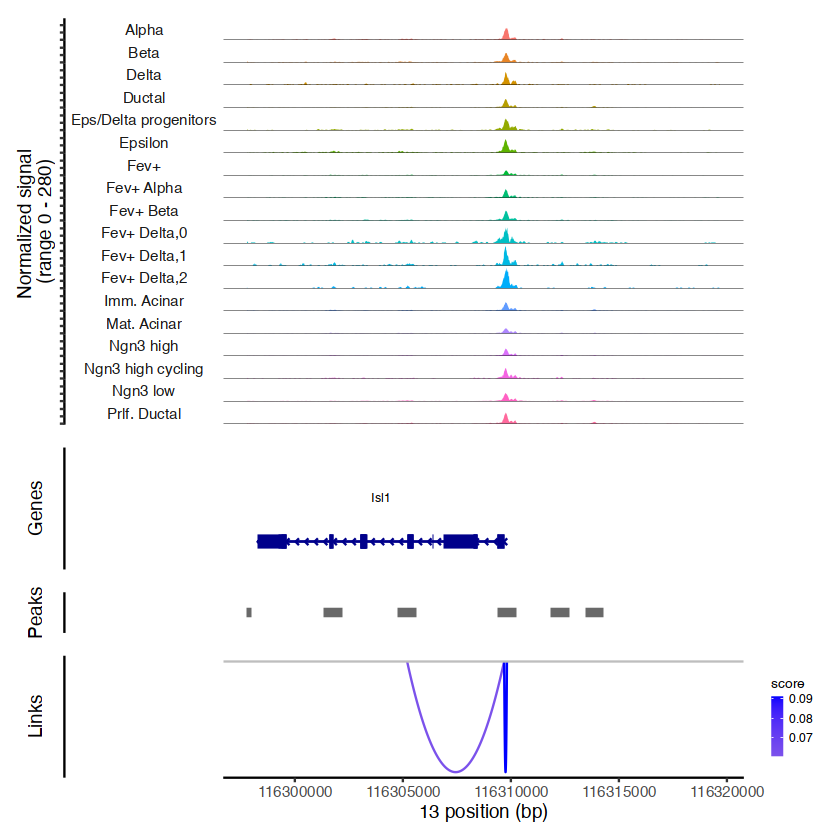

In [140]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Isl1",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

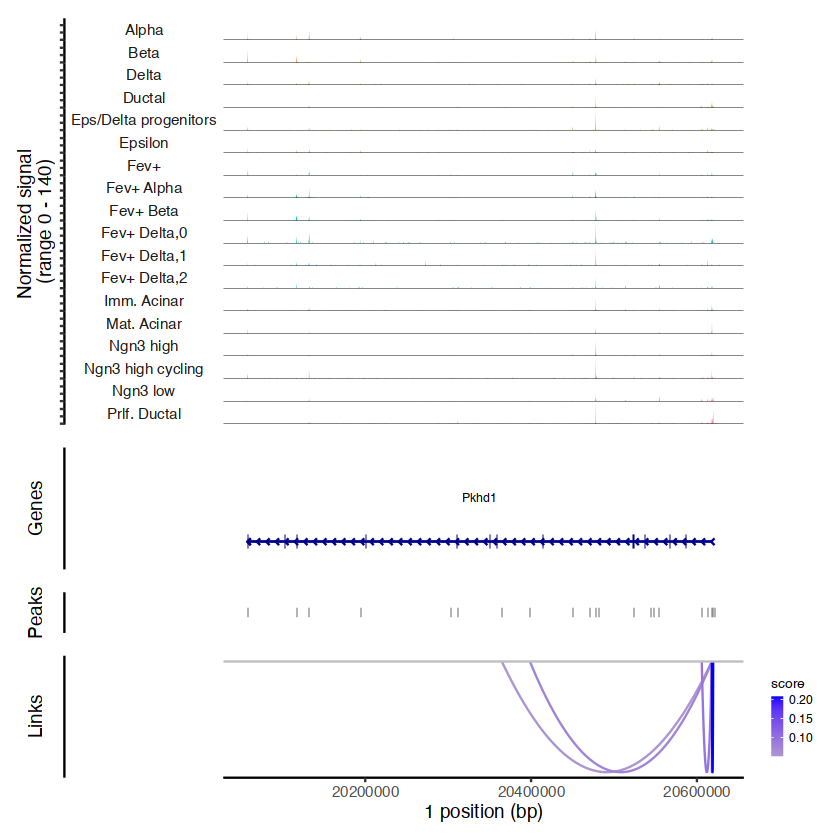

In [141]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Pkhd1",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

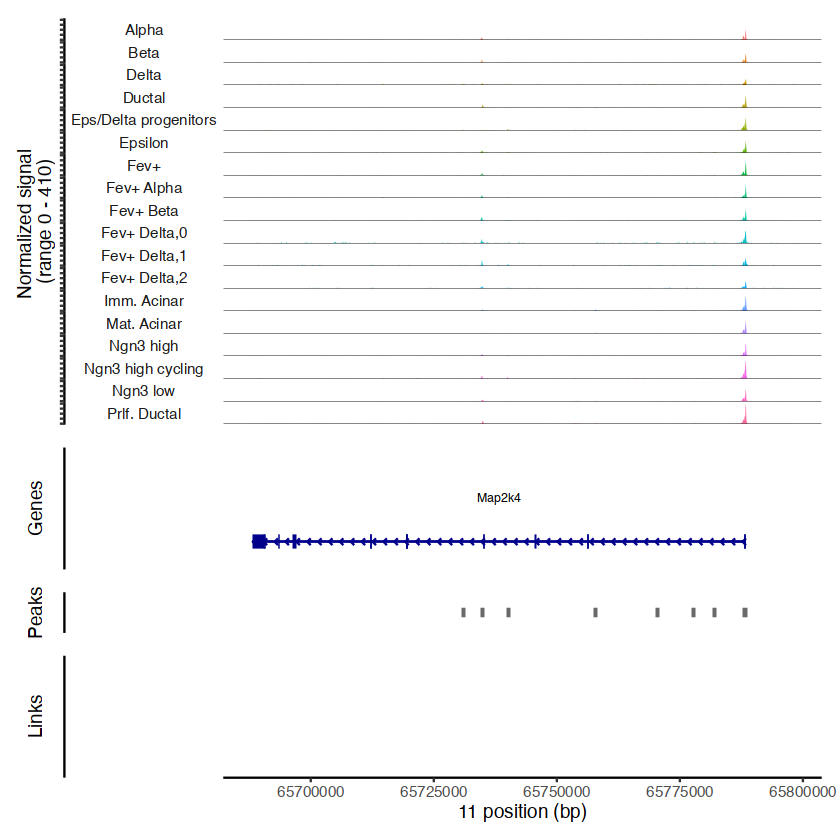

In [142]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region = "Map2k4",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"


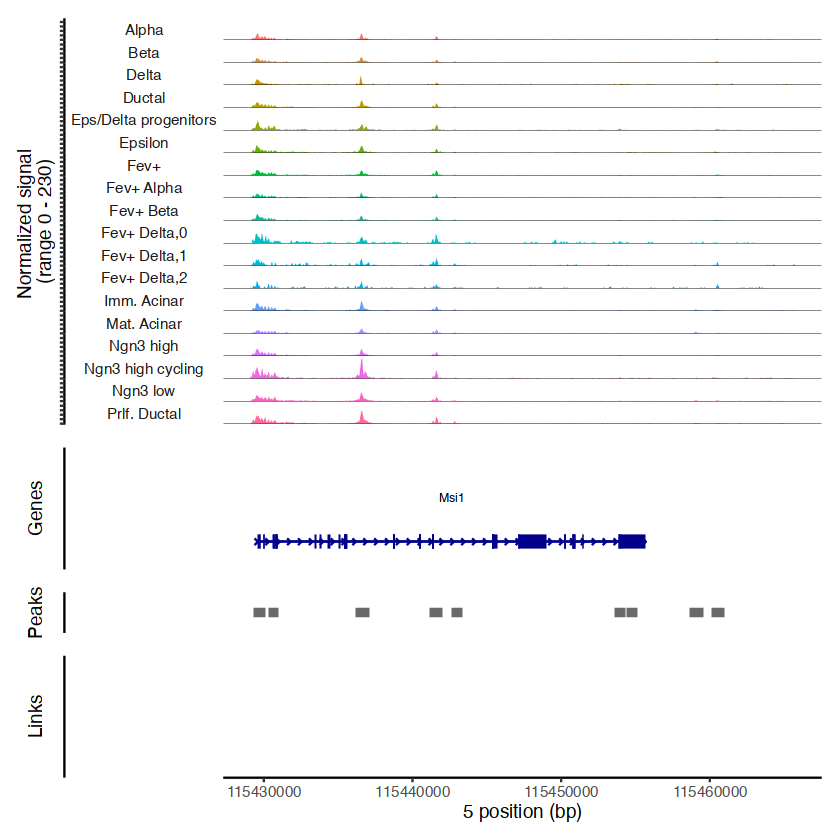

In [143]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region =  "Msi1",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message:
"Removed 7 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


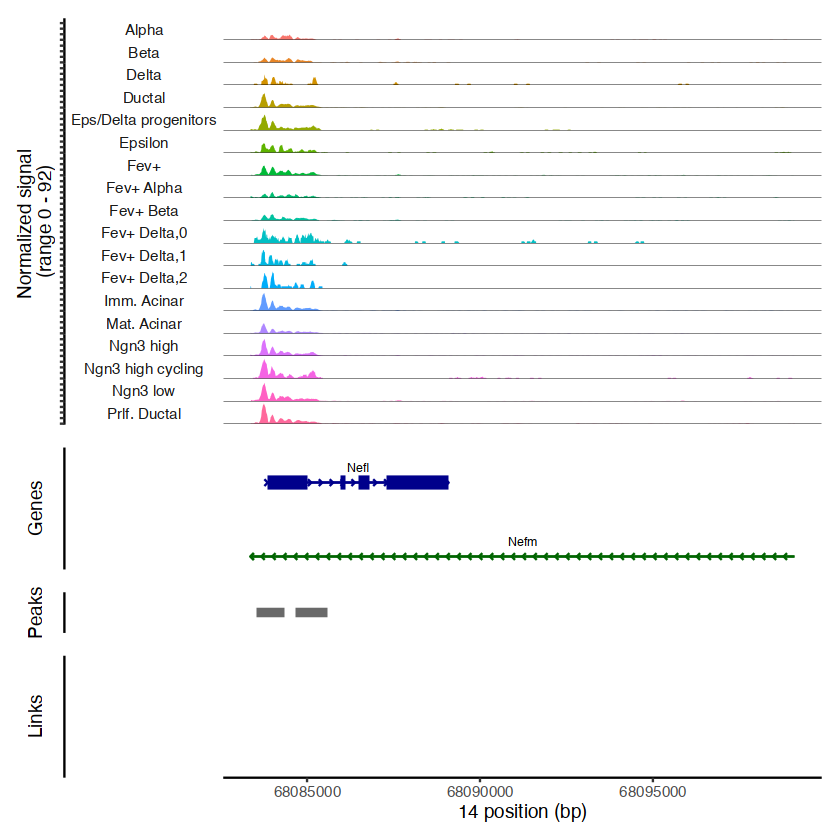

In [144]:
Idents(seurat) <- "split_fev_delta"

p1 <- CoveragePlot(
  object = seurat,
  region =  "Nefl",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

# Some Analysis on the Eps/Delta progenitors (probably only Eps progenitors)

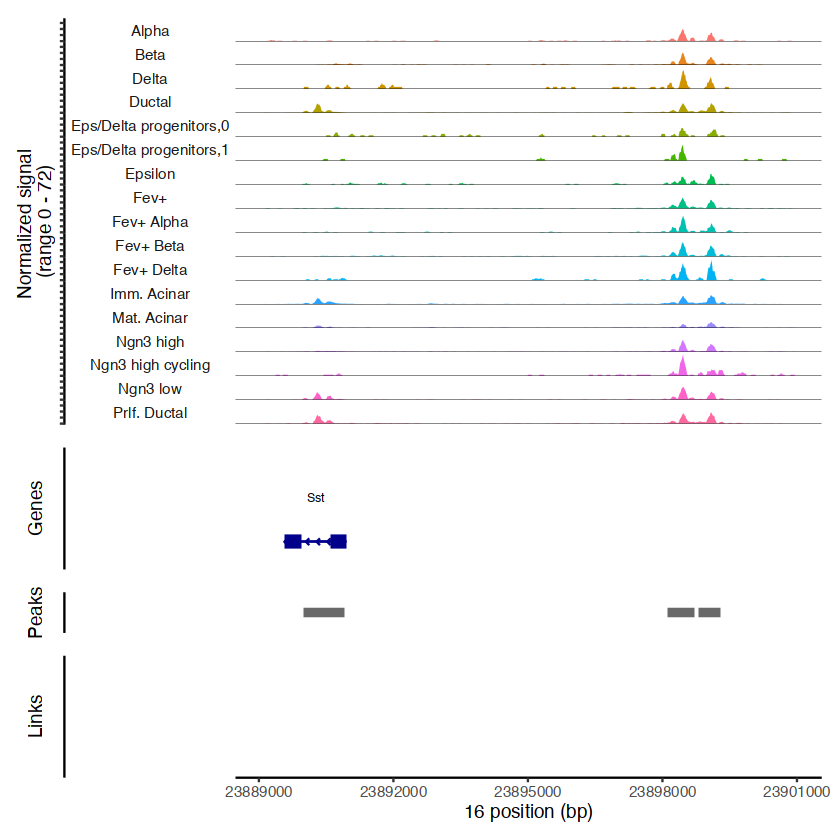

In [147]:
Idents(seurat) <- "split_eps_progenitors"

p1 <- CoveragePlot(
  object = seurat,
  region = "Sst",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

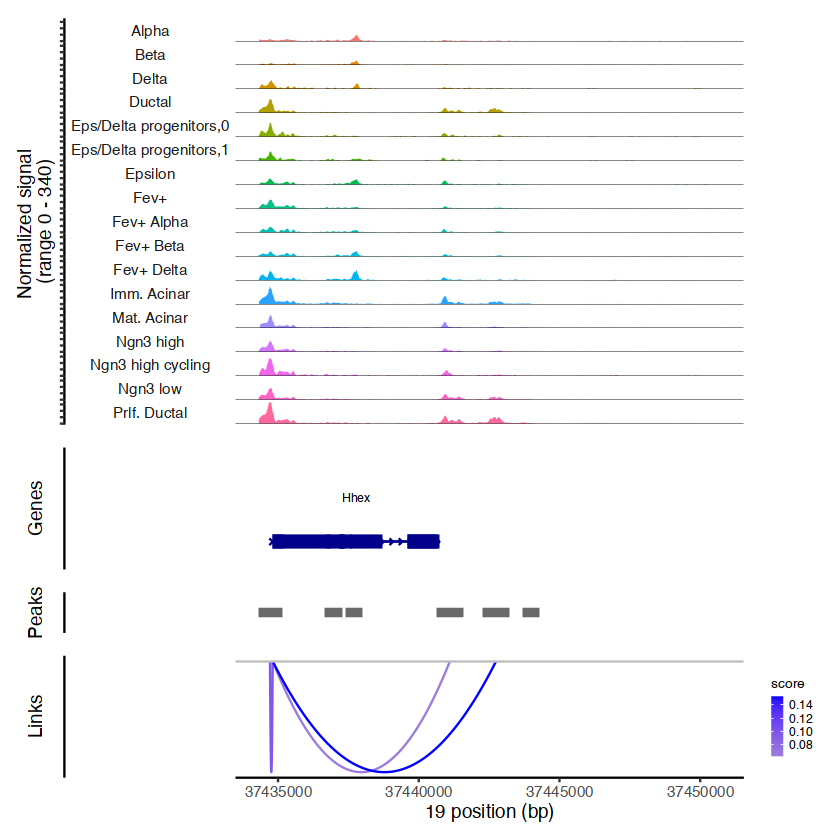

In [148]:
Idents(seurat) <- "split_eps_progenitors"

p1 <- CoveragePlot(
  object = seurat,
  region = "Hhex",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message:
"Removed 13 rows containing missing values (geom_segment)."


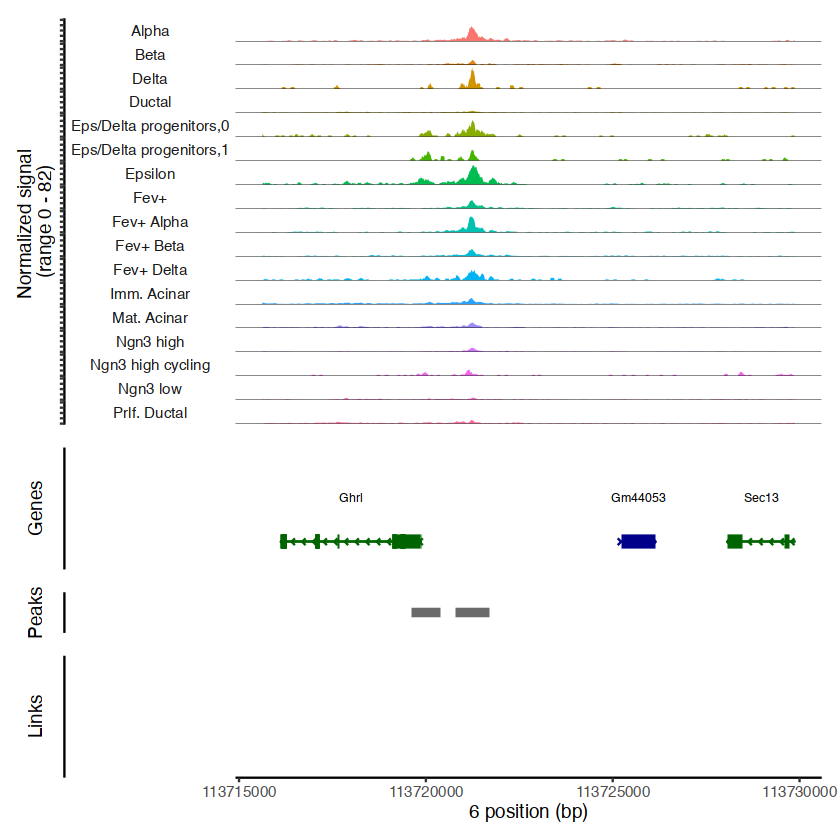

In [150]:
Idents(seurat) <- "split_eps_progenitors"

p1 <- CoveragePlot(
  object = seurat,
  region = "Ghrl",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message:
"Removed 41 rows containing missing values (geom_segment)."


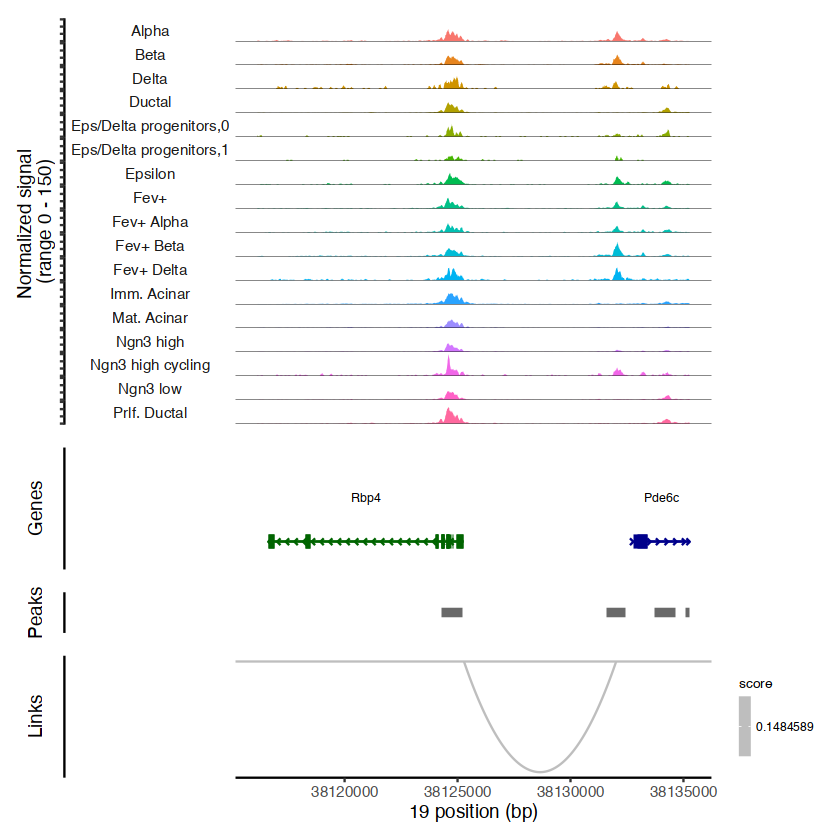

In [151]:
Idents(seurat) <- "split_eps_progenitors"

p1 <- CoveragePlot(
  object = seurat,
  region = "Rbp4",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

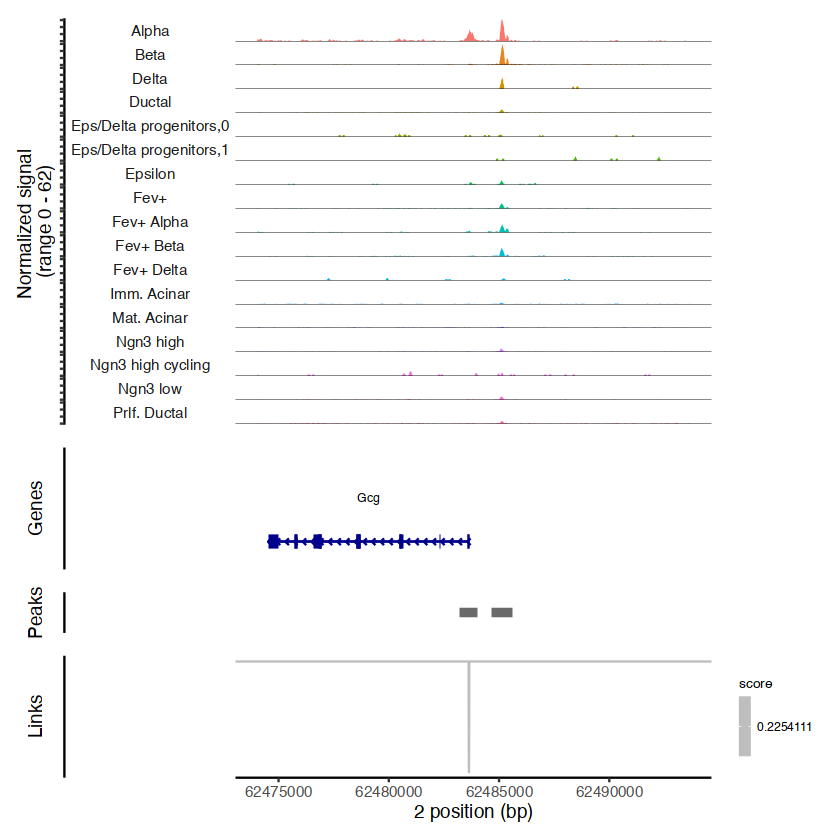

In [152]:
Idents(seurat) <- "split_eps_progenitors"

p1 <- CoveragePlot(
  object = seurat,
  region = "Gcg",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

# Some analysis on Ngn3 high

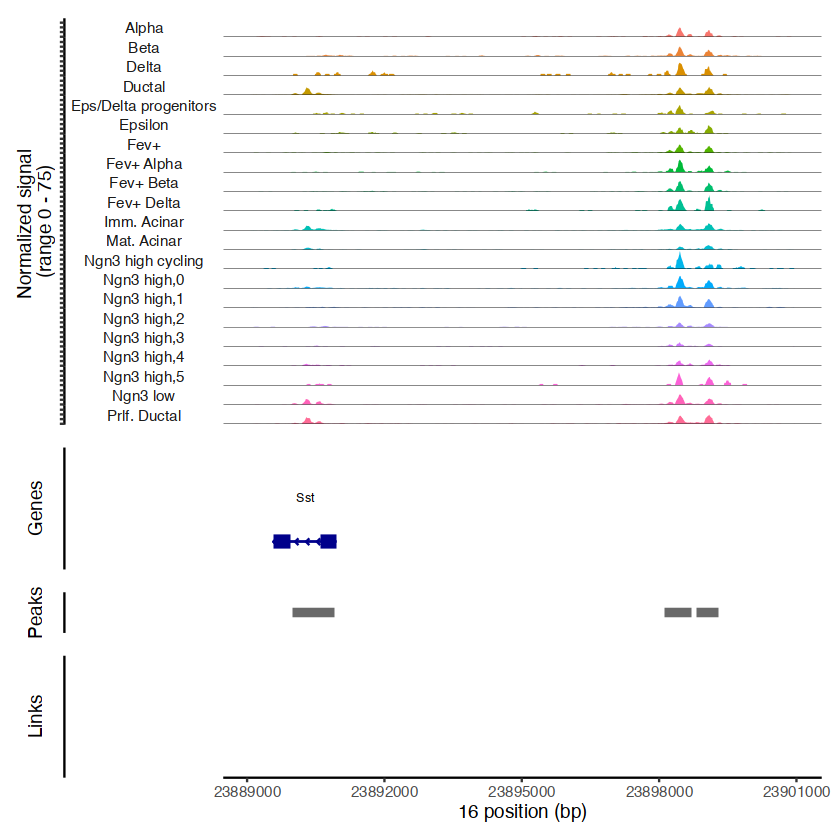

In [153]:
Idents(seurat) <- "split_ngn3_high"

p1 <- CoveragePlot(
  object = seurat,
  region = "Sst",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

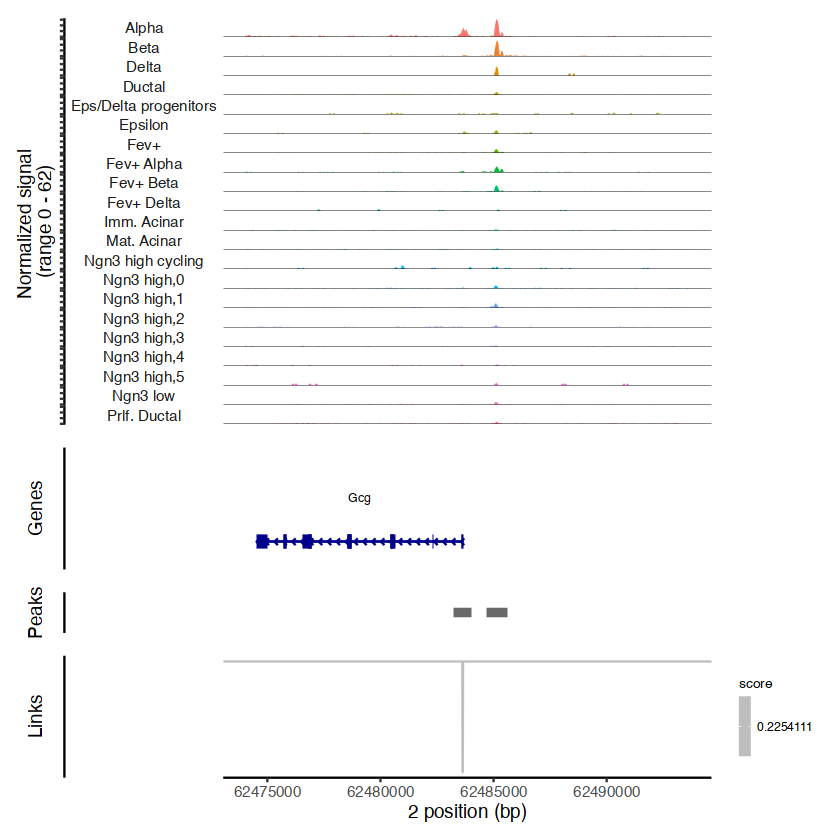

In [154]:
Idents(seurat) <- "split_ngn3_high"

p1 <- CoveragePlot(
  object = seurat,
  region = "Gcg",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

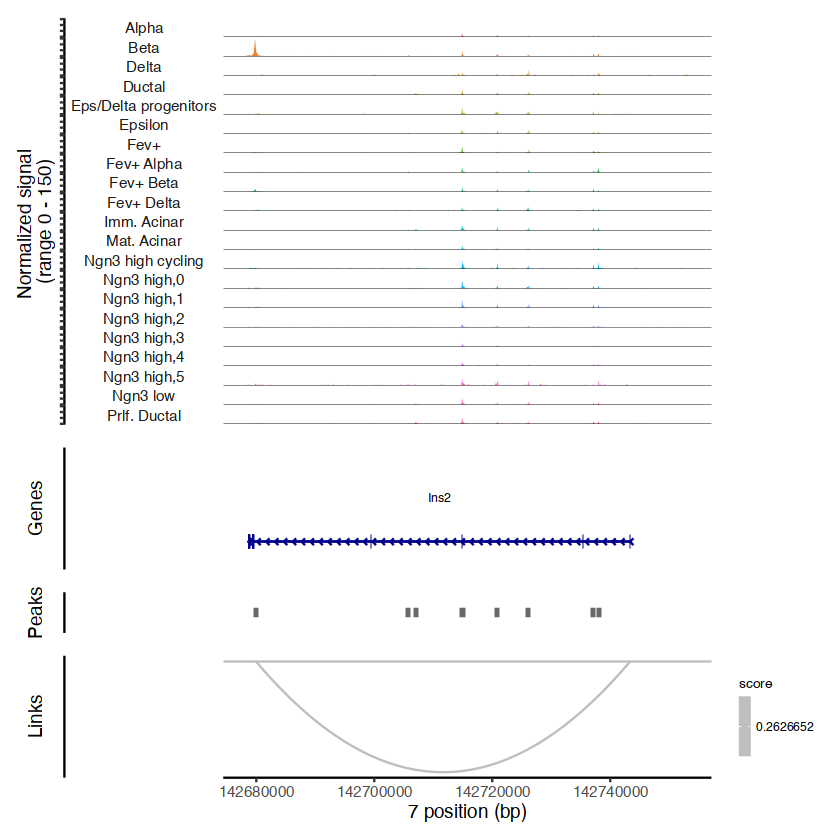

In [155]:
Idents(seurat) <- "split_ngn3_high"

p1 <- CoveragePlot(
  object = seurat,
  region = "Ins2",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message:
"Removed 13 rows containing missing values (geom_segment)."


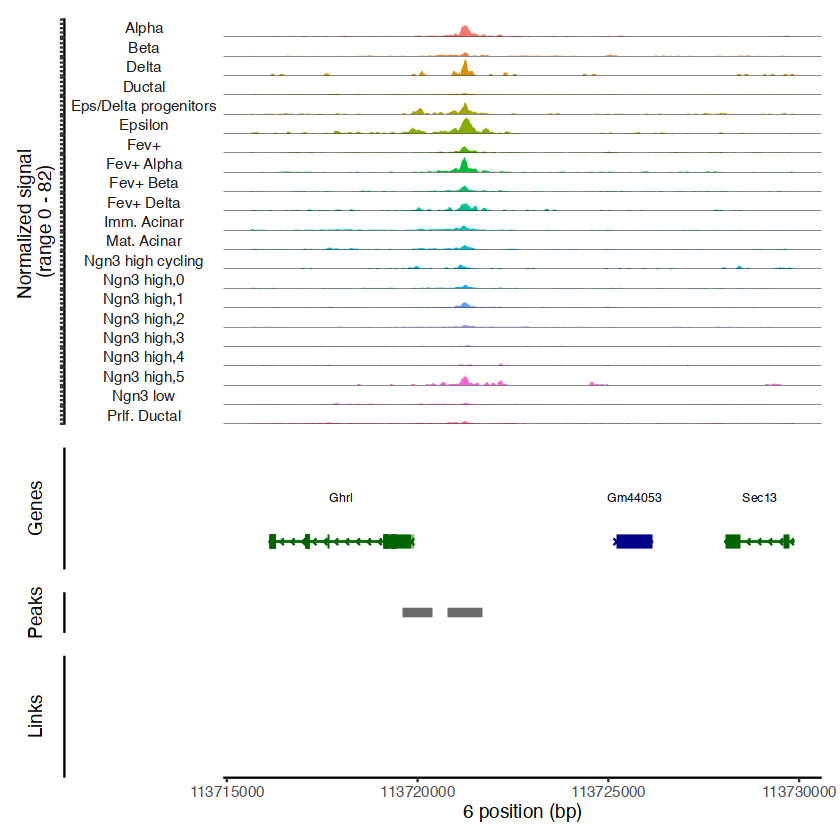

In [156]:
Idents(seurat) <- "split_ngn3_high"

p1 <- CoveragePlot(
  object = seurat,
  region = "Ghrl",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

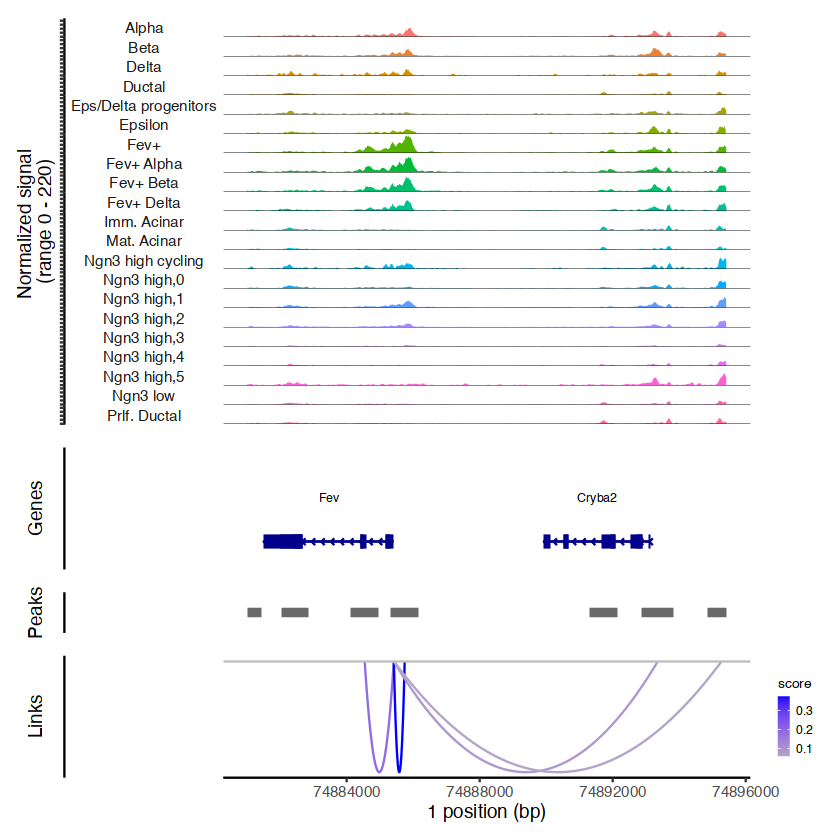

In [157]:
Idents(seurat) <- "split_ngn3_high"

p1 <- CoveragePlot(
  object = seurat,
  region = "Fev",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1

Warning message:
"Removed 27 rows containing missing values (geom_segment)."


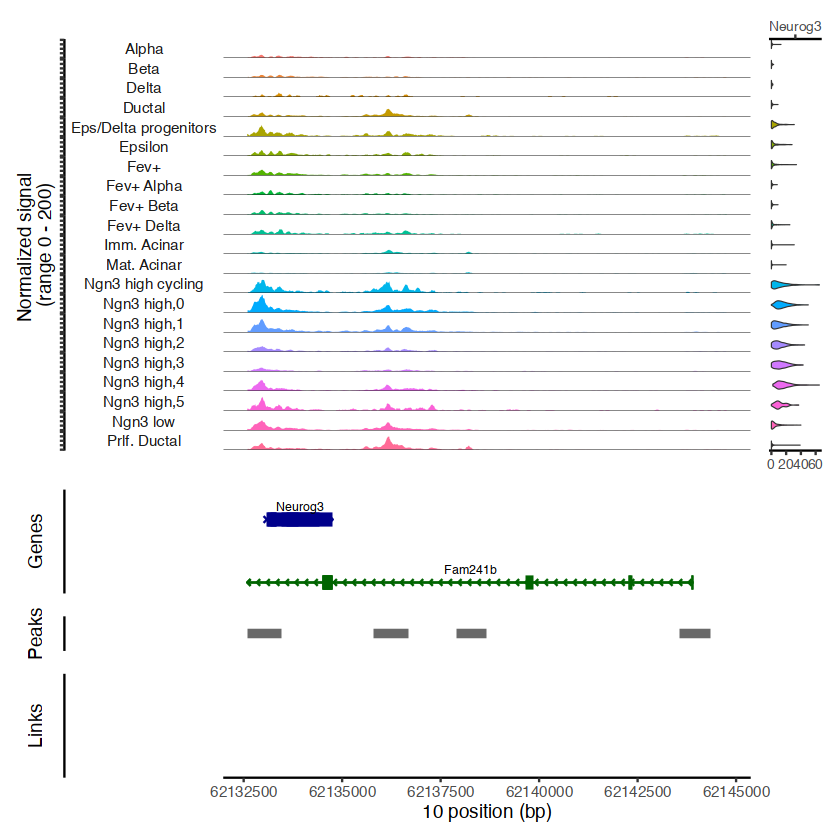

In [163]:
Idents(seurat) <- "split_ngn3_high"

p1 <- CoveragePlot(
  object = seurat,
  region = "Neurog3",
    features = "Neurog3",
  expression.assay = "RNA",
  extend.upstream = 500,
  extend.downstream = 10000,
)
p1